In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.split('.')[-1]=='csv':
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Handling GDCM error**

In [ ]:
# !pip install python-gdcm
# !pip uninstall -y pylibjpeg
# !pip uninstall -y  pylibjpeg-libjpeg
!conda install -c conda-forge gdcm -y

In [ ]:
#xray
import pydicom as dicom
from glob import glob
from tqdm.notebook import tqdm
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
# color
from colorama import Fore, Back, Style
import seaborn as sns
sns.set(style="whitegrid")
# plotly
import pprint
import plotly.express as px
import plotly
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# **Guideline**
https://journals.lww.com/thoracicimaging/Fulltext/2020/11000/Review_of_Chest_Radiograph_Findings_of_COVID_19.4.aspx

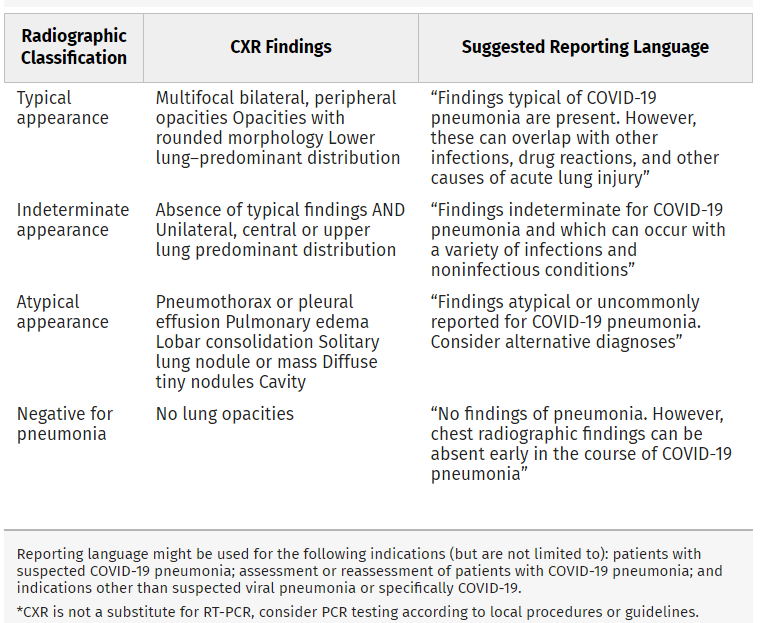]


**Zoning**

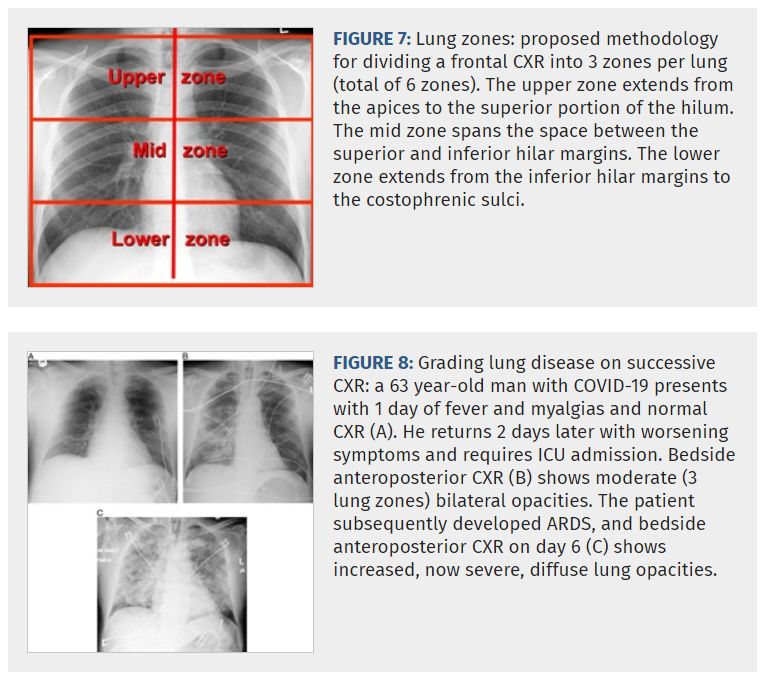]

In [ ]:
submission_df = pd.read_csv(r'/kaggle/input/siim-covid19-detection/sample_submission.csv')
train_img_level_df = pd.read_csv(r'/kaggle/input/siim-covid19-detection/train_image_level.csv')
train_study_level_df = pd.read_csv(r'/kaggle/input/siim-covid19-detection/train_study_level.csv')

# **Explore  Train_Study_level.csv**

In [ ]:
train_study_level_df.head(10)

In [ ]:

print(train_study_level_df.shape)
#check if 2 classes can be in same study image or not-
train_study_level_df['sumApperance'] = train_study_level_df['Atypical Appearance'] + train_study_level_df['Indeterminate Appearance'] \
                                    + train_study_level_df['Typical Appearance'] +\
                                    train_study_level_df['Negative for Pneumonia'] 
print('unique count',train_study_level_df['sumApperance'].nunique())

for idx,col in enumerate(train_study_level_df.columns):
    if col =='id':
        continue
    plt.figure(idx)
    sns.countplot(train_study_level_df[col])
    #train_img_level_dfproces['Negative for Pneumonia'].value_counts().index
plt.show()

In [ ]:
#check relative frequency 
#create 4 class - Negative for Pneumonia - 0 , Typical Appearance	1, Indeterminate Appearance 2, Atypical Appearance 3.
train_study_level_df['target'] = 0
train_study_level_df.loc[train_study_level_df['Atypical Appearance']==1,'target']=3
train_study_level_df.loc[train_study_level_df['Indeterminate Appearance']==1,'target']=2
train_study_level_df.loc[train_study_level_df['Typical Appearance']==1,'target']=1
plt.figure(100)
ax= sns.countplot(train_study_level_df['target'])
#plt.plot(train_img_level_dfproces['target'].value_counts().index,train_img_level_dfproces['target'].value_counts())
#plt.legend()
plt.title('Negative for Pneumonia: 0,Typical Appearance: 1, Indeterminate Appearance 2, Atypical Appearance 3')
plt.show()

# **Missing values**

In [ ]:
train_img_level_df.isnull().sum()

In [ ]:
train_study_level_df.isnull().sum()

# **Explore train_image_level.csv**

In [ ]:
train_img_level_df.head(10)

# **Merging two CSV**

In [ ]:
#merge using pandas
train_study_level_df['StudyInstanceUID'] = train_study_level_df['id'].apply(lambda x: x.replace('_study', ''))
del train_study_level_df['id']
del train_study_level_df['sumApperance']
train_merger_df = train_img_level_df.merge(train_study_level_df, on='StudyInstanceUID')
train_merger_df.head()

In [ ]:
train_merger_df.shape,train_merger_df['StudyInstanceUID'].shape,train_merger_df['StudyInstanceUID'].nunique()

**Relationship b/w train_image_level & study_level**

**Dataset information**
The train dataset comprises 6,334 chest scans in DICOM format, which were de-identified to protect patient privacy. All images were labeled by a panel of experienced radiologists for the presence of opacities as well as overall appearance.

Note that all images are stored in paths with the form **study-id/series/image-id**. The study ID here relates directly to the study-level predictions, and the image ID is the ID used for image-level predictions.

The hidden test dataset is of roughly the same scale as the training dataset.

**Files**
train_study_level.csv - the train study-level metadata, with one row for each study, including correct labels.
train_image_level.csv - the train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format. Some images in both test and train have multiple bounding boxes.
sample_submission.csv - a sample submission file **containing all image- and study-level IDs**.

In [ ]:
train_img_level_df['StudyInstanceUID'].shape,train_img_level_df['StudyInstanceUID'].nunique()

**So, same studyID is mapped to many imagees ..more than 1 image_id. Let's find such mapping**

In [ ]:
def getScorefromStudyTable(df,columnName,row_id):
    dftmp = df.loc[df[columnName]==row_id]
    result = dict()
    if dftmp.shape[0] !=1:
        print('Not a unique score')
        print(dftmp)
        raise Exception('Issue of unique score for given row id,',row_id)
    else:      
        result['Atypical Appearance'] = dftmp['Atypical Appearance'].values[0]
        result['Indeterminate Appearance'] = dftmp['Indeterminate Appearance'].values[0]
        result['Typical Appearance'] = dftmp['Typical Appearance'].values[0]
        result['Negative for Pneumonia'] = dftmp['Negative for Pneumonia'].values[0]
        result['TotalScore'] =  dftmp['Atypical Appearance'].values[0] + dftmp['Indeterminate Appearance'].values[0] \
                                    + dftmp['Typical Appearance'].values[0] +\
                                    dftmp['Negative for Pneumonia'].values[0] 
    return result

In [ ]:
values = train_img_level_df['StudyInstanceUID'].value_counts().keys().tolist()
counts = train_img_level_df['StudyInstanceUID'].value_counts().tolist()
print(len(values),len(counts))
studyID2imageID = {}
#Find all 1 to many - study ID and its image ID 
maxInfo = 5
count=0
for idx,item in enumerate(values):
    if count > maxInfo:
        break
    if counts[idx] ==1:
        continue
    else:
        studyID2imageID[item]= counts[idx]
        print('*'*50)
        print('Study id -',item)
        #print(train_study_level_df.loc[train_study_level_df['StudyInstanceUID']==item])
        r = getScorefromStudyTable(train_study_level_df,'StudyInstanceUID',item)
        imgdf = train_img_level_df.loc[train_img_level_df['StudyInstanceUID']==item]
        print(r)
        for index,row in imgdf.iterrows():
            print(index,row['id'],row['boxes'],row['label'])
        print('*'*75)
        
        count +=1
#studyID2imageID

In [ ]:
if False:
    train_img_level_df_process = train_img_level_df.copy()
    #merging study & image tabel - using loiops - not good approch.
    #Negative for Pneumonia - 0 , Typical Appearance	1, Indeterminate Appearance 2, Atypical Appearance 3, target
    train_img_level_df_process['Negative for Pneumonia'] = -1
    train_img_level_df_process['Typical Appearance'] = -1
    train_img_level_df_process['Indeterminate Appearance'] = -1
    train_img_level_df_process['Atypical Appearance'] = -1
    train_img_level_df_process['target'] = -1
    runcount = 0
    for row in train_img_level_df_process['StudyInstanceUID']:#.iterrows():
        runcount +=1
        studyid = f"{row}_study"
        #print(studyid)
        df_found = train_study_level_df.loc[train_study_level_df['id']==studyid]
        #print(df_found['target'].values[0])
        train_img_level_df_process.loc[train_img_level_df_process['StudyInstanceUID']==row,'target'] = df_found['target'].values[0]
        train_img_level_df_process.loc[train_img_level_df_process['StudyInstanceUID']==row,'Atypical Appearance'] = df_found['Atypical Appearance'].values[0]
        train_img_level_df_process.loc[train_img_level_df_process['StudyInstanceUID']==row,'Indeterminate Appearance'] = df_found['Indeterminate Appearance'].values[0]
        train_img_level_df_process.loc[train_img_level_df_process['StudyInstanceUID']==row,'Typical Appearance'] = df_found['Typical Appearance'].values[0]
        train_img_level_df_process.loc[train_img_level_df_process['StudyInstanceUID']==row,'Negative for Pneumonia'] = df_found['Negative for Pneumonia'].values[0]
        #break
        #if runcount > 5:
        #    break

    train_img_level_df_process.head(10)

**Dicom Data**

Taken from - https://www.kaggle.com/ruchi798/siim-covid-19-detection-eda-data-augmentation

In [ ]:
voi_lut=True
fix_monochrome=True
def dicom_dataset_to_dict(filename):
    """Credit: https://github.com/pydicom/pydicom/issues/319
               https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    """
    
    dicom_header = dicom.dcmread(filename) 
    #====== DICOM FILE DATA ======
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7fe0, 0x0010):
            #discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v
      
    del dicom_dict['Pixel Representation']
    
    #====== DICOM IMAGE DATA ======
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom_header.pixel_array, dicom_header)
    else:
        data = dicom_header.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom_header.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    modified_image_data = (data * 255).astype(np.uint8)
    
    return dicom_dict, modified_image_data

def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()

def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode('ascii', 'replace')
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv


**Plot sample image**

In [ ]:
if True:
    #filename = r'../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm'
    filename = r'/kaggle/input/siim-covid19-detection/train/ff0879eb20ed/d8a644cc4f93/000c3a3f293f.dcm'
    df, img_array = dicom_dataset_to_dict(filename)
    fig, ax = plt.subplots(1, 2, figsize=[10, 8])
    ax[0].imshow(img_array, cmap=plt.cm.gray)
    ax[1].imshow(img_array, cmap=plt.cm.plasma)    
    plt.show()
    
    pprint.pprint(df)

# **Collect image path for Study Id**

In [ ]:
import glob
def findImages(rootfolder):
    listOfimages = glob.glob(os.path.join(rootfolder,'*/*.dcm'))+glob.glob(os.path.join(rootfolder,'*/*/*.dcm'))
    return listOfimages

folderpathTrain = r'/kaggle/input/siim-covid19-detection/train'
imgListTrain = findImages(folderpathTrain)
#print(imgListTrain[:10])
folderpathTest = r'/kaggle/input/siim-covid19-detection/test'
imgListTest = findImages(folderpathTest)
#print(imgListTest[:10])
print('#imgListTest,#imgListTrain',len(imgListTest),len(imgListTrain))

**Any overlap b/w test & train image**

In [ ]:
testbasenameList = [os.path.basename(file) for file in imgListTest]
#print(testbasenameList[:10])
commonFile = []
for file in imgListTrain:
    basename = os.path.basename(file)
    #print(basename)
    if basename in testbasenameList:
        #print(file)
        commonFile.append(file)

if len(commonFile)>0:
    print('Found common files-',commonFile)
else:
    print('No common files')

# **DICOM to PNG**

**plot few images**

In [ ]:
for imgpath in imgListTrain[:5]:
    df, img_array = dicom_dataset_to_dict(imgpath)
    fig, ax = plt.subplots(1, 2, figsize=[10, 8])
    ax[0].imshow(img_array, cmap=plt.cm.gray)
    ax[1].imshow(img_array, cmap=plt.cm.plasma)    
    plt.show()

# **Get Kfolds**

In [ ]:
from sklearn.model_selection import StratifiedKFold
nFolds = 3
train_merger_df['kfold'] = -1
skf = StratifiedKFold(n_splits=nFolds, shuffle=True, random_state=123)
images = train_merger_df['id']
target = train_merger_df['target']
for fold, (train_idx, valid_idx) in enumerate(skf.split(images, target)):
    train_merger_df.loc[valid_idx, 'kfold'] = fold

In [ ]:
sns.countplot(train_merger_df['kfold'])
plt.show()

In [ ]:
def savedcmtopng(index,rowid,trainFolder,localdir):
    global train_merger_df
    global save_png,plot_image_with_bbox,plot_flag
    #print(index,rowid,trainFolder,localdir)
    image = rowid.id
    bbox = rowid.boxes
    label = rowid.label
    target = rowid.target
    studyUID = rowid.StudyInstanceUID
    
    studyfolder = os.path.join(trainFolder,studyUID)
    folders = os.listdir(studyfolder)
    dcmfolder = os.path.join(studyfolder,folders[0])
    files = glob.glob(os.path.join(dcmfolder,'*.dcm'))
    dcm_path = files[0]
    firstname = os.path.basename(dcm_path)
    firstname_noextn = firstname.split('.')[0]
    try:
        df, img_array = dicom_dataset_to_dict(dcm_path)
        H,W = img_array.shape
        if save_png:
            png_path = os.path.join(localdir,f"{firstname_noextn}.png")
            if resize_flag:
                img_array_sz = cv2.resize(img_array,resize_dims,interpolation=cv2.INTER_LINEAR)
            else:
                img_array_sz = img_array
            cv2.imwrite(png_path,img_array_sz)
        if plot_image_with_bbox != -1 and plot_flag and isinstance(bbox,list):
            img_plot = np.stack([img_array]*3,axis=-1)
            plot_count += 1
            bbox = eval(bbox)
            numBox = len(bbox)
            print(bbox)
            for idbox in range(numBox):
                item = bbox[idbox]
                x = int(item['x'])
                y = int(item['y'])
                width = int(item['width'])
                height = int(item['height'])
                #print(x,y,width,height)
                cv2.rectangle(img_plot,(x,y),(x+width,y+height),(255,0,0),20)
            plt.imshow(img_plot)
            if plot_count >= plot_image_with_bbox:
                plot_flag = False
                #break
            plt.show()
    except Exception as e:
        H = -1
        W = -1
        png_path = None
        print(image,dcm_path,e,bbox)
        
    train_merger_df.loc[index,'dcm_path']= dcm_path
    train_merger_df.loc[index,'height']= H
    train_merger_df.loc[index,'width']= W
    train_merger_df.loc[index,'png_path']= png_path

# **Update the path of image in merge table**

In [ ]:
import shutil
import matplotlib.pyplot as plt
localdir = os.path.join('.','train')
#shutil.rmtree(localdir)
os.makedirs(localdir,exist_ok=True)
train_merger_df['dcm_path'] = None
train_merger_df['width'] = None
train_merger_df['height'] = None
train_merger_df['png_path'] = None
trainFolder = r'/kaggle/input/siim-covid19-detection/train'
testFolder = r'/kaggle/input/siim-covid19-detection/test'

save_png = True
plot_image_with_bbox = 10 #-1 for no plot
plot_count = 0
plot_flag = False#True
resize_flag = True
resize_dims = (512,512)
if False:
    for index,rowid in train_merger_df.iterrows():
        image = rowid.id
        bbox = rowid.boxes
        label = rowid.label
        target = rowid.target
        studyUID = rowid.StudyInstanceUID

        studyfolder = os.path.join(trainFolder,studyUID)
        folders = os.listdir(studyfolder)
        dcmfolder = os.path.join(studyfolder,folders[0])
        files = glob.glob(os.path.join(dcmfolder,'*.dcm'))
        dcm_path = files[0]
        firstname = os.path.basename(dcm_path)
        firstname_noextn = firstname.split('.')[0]
        try:
            df, img_array = dicom_dataset_to_dict(dcm_path)
            H,W = img_array.shape
            if save_png:
                png_path = os.path.join(localdir,f"{firstname_noextn}.png")
                if resize_flag:
                    img_array_sz = cv2.resize(img_array,resize_dims,interpolation=cv2.INTER_LINEAR)
                else:
                    img_array_sz = img_array
                cv2.imwrite(png_path,img_array_sz)
            if plot_image_with_bbox != -1 and plot_flag and isinstance(bbox,list):
                img_plot = np.stack([img_array]*3,axis=-1)
                plot_count += 1
                bbox = eval(bbox)
                numBox = len(bbox)
                print(bbox)
                for idbox in range(numBox):
                    item = bbox[idbox]
                    x = int(item['x'])
                    y = int(item['y'])
                    width = int(item['width'])
                    height = int(item['height'])
                    #print(x,y,width,height)
                    cv2.rectangle(img_plot,(x,y),(x+width,y+height),(255,0,0),20)
                plt.imshow(img_plot)
                if plot_count >= plot_image_with_bbox:
                    plot_flag = False
                    break
                plt.show()
        except Exception as e:
            H = -1
            W = -1
            png_path = None
            print(image,dcm_path,e,bbox)

        train_merger_df.loc[index,'dcm_path']= dcm_path
        train_merger_df.loc[index,'height']= H
        train_merger_df.loc[index,'width']= W
        train_merger_df.loc[index,'png_path']= png_path
    

In [ ]:
from concurrent.futures import ThreadPoolExecutor,as_completed
with ThreadPoolExecutor(max_workers=4) as executor:
    futureObjs = []
    for index,rowid in train_merger_df.iterrows():
        #savedcmtopng(index,rowid,trainFolder,localdir)
        #break
        futureObjs.append(executor.submit(savedcmtopng, index,rowid,trainFolder,localdir))
    #for fut in as_completed(futureObjs):
    #    print(fut)
print('Parallel Done')

In [ ]:
train_merger_df.head(10)

In [ ]:
train_merger_df.to_csv(r'/kaggle/working/train_data.csv')

In [ ]:
!cd /kaggle/working

In [ ]:
!zip -r train_patches_512.zip train

In [ ]:
#!tar -zcf train_patches_512.tar.gz /kaggle/working/train

In [ ]:
print('done')

In [ ]:
from IPython.display import FileLink
FileLink('train_patches_512.zip')

In [ ]:
# https://www.kaggle.com/sumitjha19/pytorch-starter-fasterrcnn-train-v2
# https://www.kaggle.com/sumitjha19/fasterrcnn-with-dataaug-yolov3-and-kfolds-wip
# https://www.kaggle.com/sumitjha19/pytorch-starter-fasterrcnn-train-v2
# https://www.kaggle.com/sumitjha19/pytorch-starter-fasterrcnn-inference
#https://www.kaggle.com/sumitjha19/data-exploration-training-data-prp
    